# Concrete Compressive Strength Prediction

## Problem Statement
Predict the compressive strength of concrete based on its ingredient composition. Compressive strength is a critical quality metric in construction, and accurately predicting it can help optimize concrete mix designs and reduce material testing costs.

## Dataset
The dataset contains 8 input features (cement, water, aggregates, etc.) and 1 target variable (compressive strength in MPa).

In [23]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib

## 1. Data Loading and Exploration

In [24]:
# Load the dataset
df = pd.read_csv("Concrete Compressive Strength.csv")
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [25]:
# Check data dimensions and missing values
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values per column:\n{df.isna().sum()}")

Dataset shape: (1030, 9)

Missing values per column:
Cement                            0
Blast Furnace Slag                0
Fly Ash                           0
Water                             0
Superplasticizer                  0
Coarse Aggregate                  1
Fine Aggregate                    0
Age (day)                         0
Concrete compressive strength     0
dtype: int64


## 2. Data Preprocessing

Handle missing values by imputing with the mean of the respective column.

In [26]:
# Calculate mean for Coarse Aggregate column
avg_coarse_aggregate = df["Coarse Aggregate"].astype("float").mean(axis=0)
print(f"Average Coarse Aggregate: {avg_coarse_aggregate:.2f}")

Average Coarse Aggregate: 972.96


In [27]:
# Replace NaN values with mean
df["Coarse Aggregate"] = df["Coarse Aggregate"].replace(np.nan, avg_coarse_aggregate)
print(f"Missing values after imputation: {df.isna().sum().sum()}")
df.head()

Missing values after imputation: 0


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## 3. Feature and Target Separation

In [28]:
# Separate features (X) and target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

print("Target variable (Compressive Strength):")
print(y.head())

Target variable (Compressive Strength):
0    79.986111
1    61.887366
2    40.269535
3    41.052780
4    44.296075
Name: Concrete compressive strength , dtype: float64


## 4. Exploratory Data Analysis (EDA)

### 4.1 Feature Distributions

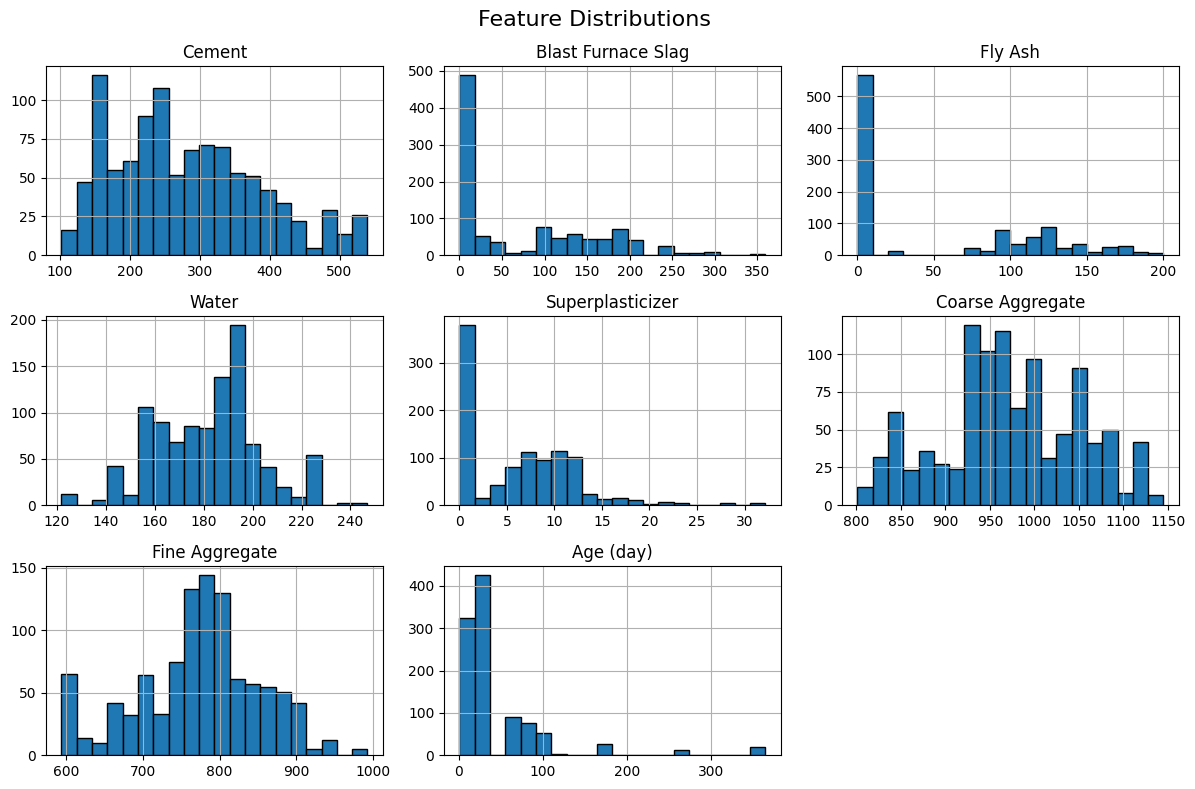

In [29]:
# Visualize feature distributions
X.hist(figsize=(12,8), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

### 4.2 Feature Correlations

Understanding correlations helps identify multicollinearity and feature relationships.

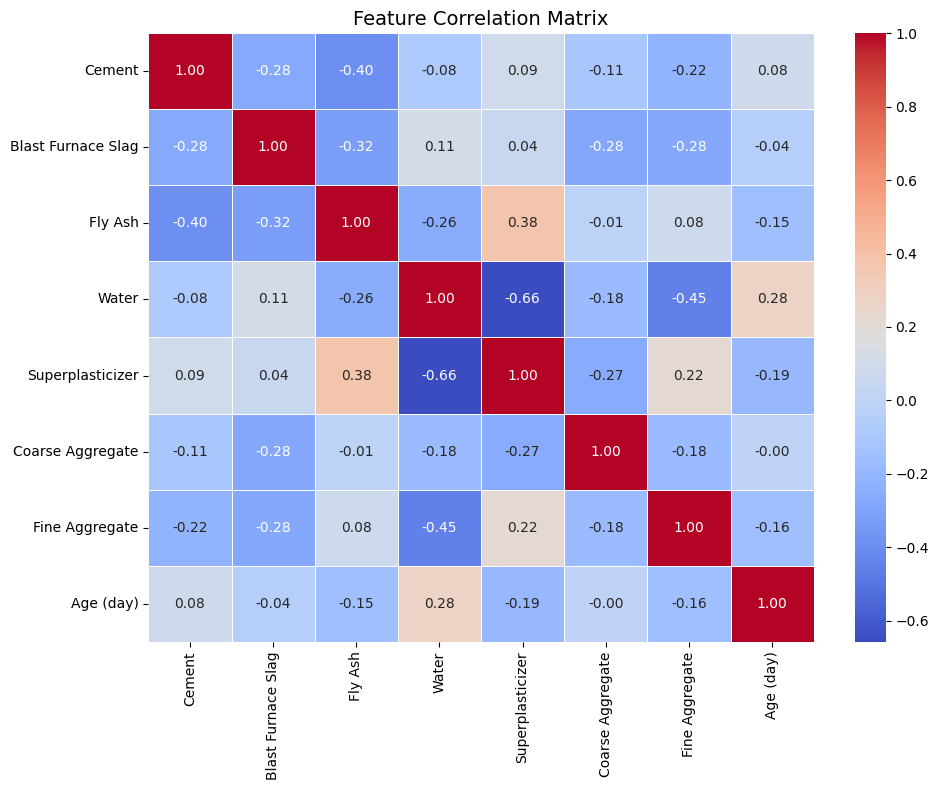

In [30]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Model Training and Evaluation

### 5.1 Train-Test Split and Baseline Model

In [31]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Baseline model: predict mean of training set
baseline_pred = np.mean(y_train)
rmse_baseline = math.sqrt(mean_squared_error(y_test, [baseline_pred]*len(y_test)))
print(f"Baseline RMSE (predicting mean): {rmse_baseline:.3f} MPa")

Baseline RMSE (predicting mean): 16.291 MPa


### 5.2 Feature Scaling

Standardize features to have zero mean and unit variance for better model performance.

In [32]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

### 5.3 Model Comparison using Cross-Validation

Compare multiple regression models to find the best performer.

In [33]:
def cv_rmse(model):
    """Calculate mean 5-fold cross-validation RMSE"""
    scores = cross_val_score(model, X_train_s, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)
    return -scores.mean()

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0)
}

# Evaluate each model
print("Model Comparison (5-Fold Cross-Validation RMSE):\n")
for name, model in models.items():
    rmse = cv_rmse(model)
    print(f"{name:20s}: {rmse:.3f} MPa")

Model Comparison (5-Fold Cross-Validation RMSE):

Linear Regression   : 10.646 MPa
Ridge Regression    : 10.646 MPa
Random Forest       : 5.419 MPa


## 6. Feature Importance Analysis

### 6.1 Random Forest Feature Importance

Random Forest provides feature importance based on how much each feature contributes to reducing prediction error.

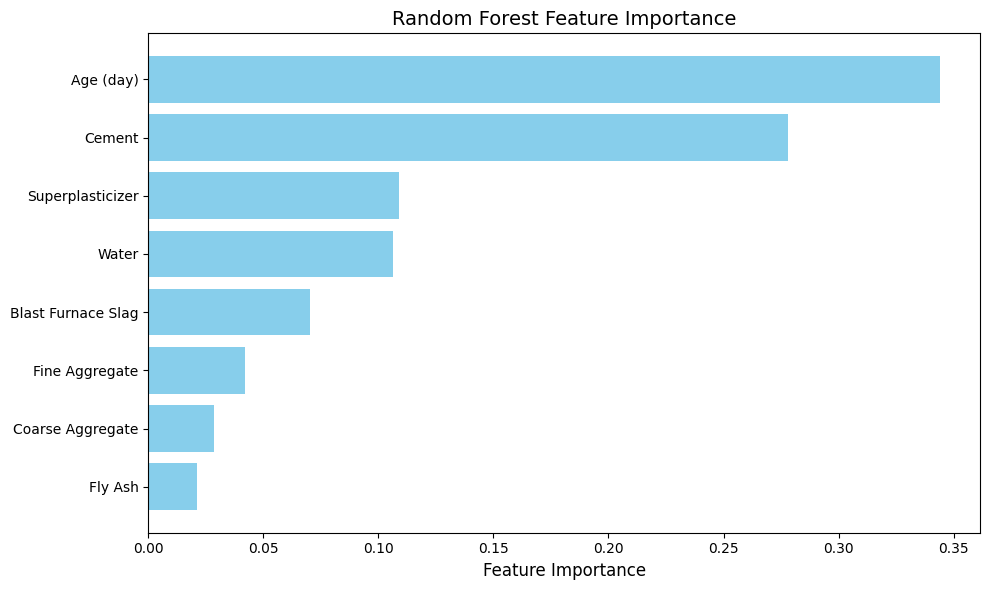

In [34]:
# Train Random Forest and extract feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Random Forest Feature Importance", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 6.2 Linear Regression Coefficients

Coefficient magnitudes indicate feature impact on predictions (after scaling).

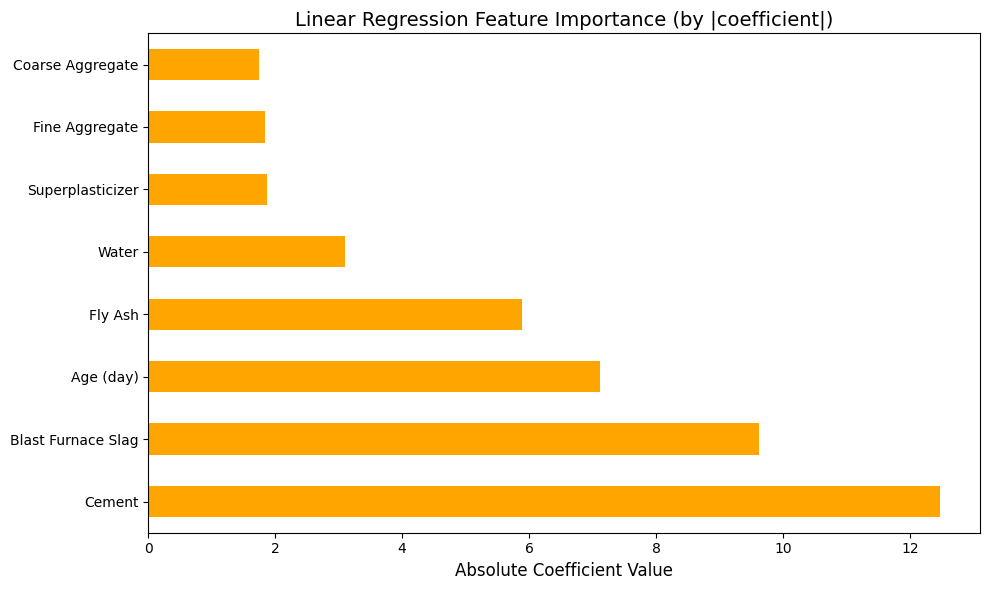

In [35]:
# Train Linear Regression and extract coefficients
lr_model = LinearRegression()
lr_model.fit(X_train_s, y_train)

coefs = pd.Series(lr_model.coef_, index=X_train.columns)

# Plot coefficient magnitudes
plt.figure(figsize=(10,6))
coefs.abs().sort_values(ascending=False).plot(kind='barh', color="orange")
plt.xlabel("Absolute Coefficient Value", fontsize=12)
plt.title("Linear Regression Feature Importance (by |coefficient|)", fontsize=14)
plt.tight_layout()
plt.show()

## 7. Final Model Training and Evaluation

Based on cross-validation results, Random Forest performed best. We'll train it on the full training set and evaluate on test set.

In [36]:
# Train final Random Forest model
final_model = RandomForestRegressor(n_estimators=100, random_state=0)
final_model.fit(X_train_s, y_train)

# Make predictions on test set
y_pred = final_model.predict(X_test_s)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Final Model Performance on Test Set:")
print(f"  RMSE: {rmse:.3f} MPa")
print(f"  R² Score: {r2:.3f}")
print(f"\nImprovement over baseline: {((rmse_baseline - rmse) / rmse_baseline * 100):.1f}%")

Final Model Performance on Test Set:
  RMSE: 4.439 MPa
  R² Score: 0.925

Improvement over baseline: 72.8%


## 8. Model Persistence

Save the trained model and scaler for future deployment.

In [37]:
# Save model and scaler
joblib.dump(final_model, "concrete_strength_model.joblib")
joblib.dump(scaler, "feature_scaler.joblib")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!


## 9. Advanced Analysis: Dimensionality Reduction and Clustering

### 9.1 & 2 Principal Component Analysis (PCA) and SCREE plot

PCA helps visualize high-dimensional data and understand variance structure.

In [38]:
# Scale full dataset for PCA
X_scaled = scaler.fit_transform(X)

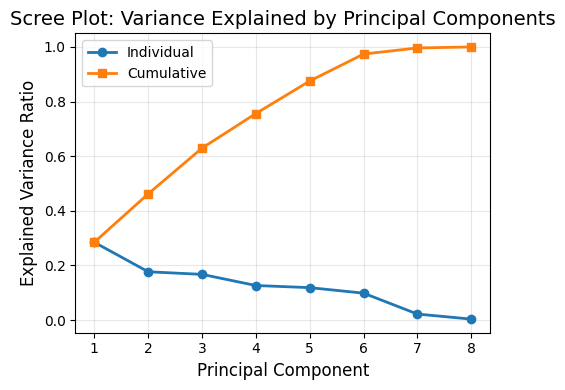

Variance explained by first 2 PCs: 46.21%
Variance explained by first 3 PCs: 62.96%


In [40]:
# Perform PCA and get explained variance ratios
pca = PCA().fit(X_scaled)
evr = pca.explained_variance_ratio_

# Create scree plot
plt.figure(figsize=(5,4))
components = range(1, len(evr)+1)
plt.plot(components, evr, 'o-', linewidth=2, label='Individual')
plt.plot(components, evr.cumsum(), 's-', linewidth=2, label='Cumulative')
plt.xlabel("Principal Component", fontsize=12)
plt.ylabel("Explained Variance Ratio", fontsize=12)
plt.title("Scree Plot: Variance Explained by Principal Components", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Variance explained by first 2 PCs: {evr[:2].sum():.2%}")
print(f"Variance explained by first 3 PCs: {evr[:3].sum():.2%}")

### 9.3 2D Visualization (PC1 vs PC2)

Project data onto first two principal components, colored by compressive strength.

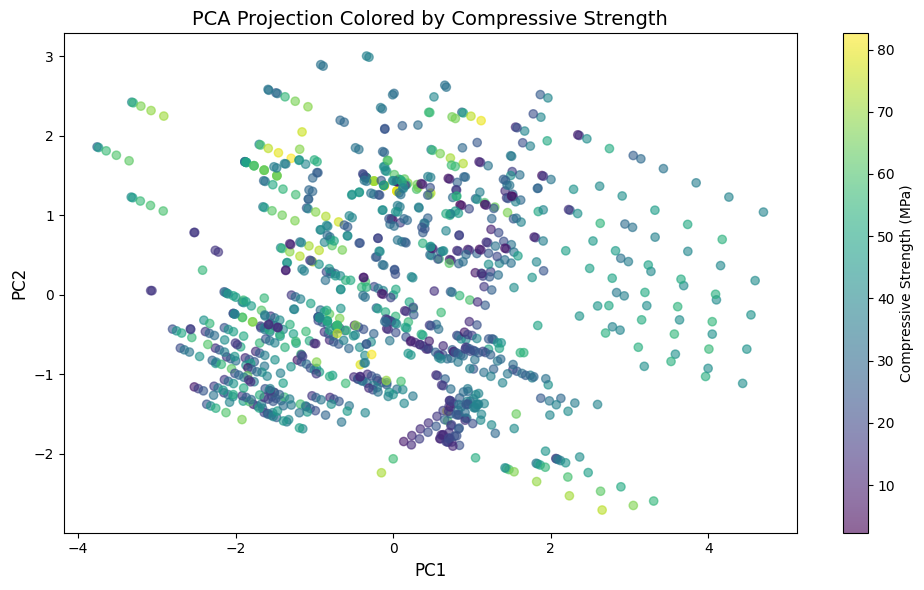

In [ ]:
# Transform data to 2D using PCA
X_pca2 = PCA(n_components=2).fit_transform(X_scaled)

# Create scatter plot
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Compressive Strength (MPa)')
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.title('PCA Projection Colored by Compressive Strength', fontsize=14)
plt.tight_layout()
plt.show()

### 9.4 Feature Loading Biplot

Shows which original features contribute most to PC1 and PC2.

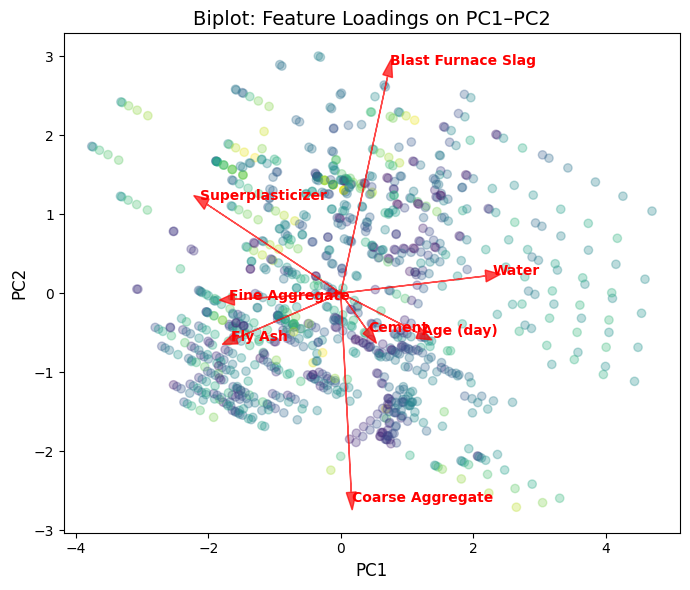

In [41]:
# Get PCA loadings
pca_full = PCA(n_components=2).fit(X_scaled)
loadings = pca_full.components_.T

# Create biplot
plt.figure(figsize=(7,6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=y, cmap='viridis', alpha=0.3)

# Plot feature vectors
for i, (xv, yv) in enumerate(loadings):
    plt.arrow(0, 0, xv*4, yv*4, color='red', head_width=0.15, alpha=0.7)
    plt.text(xv*4.2, yv*4.2, X.columns[i], color='red', fontsize=10, fontweight='bold')

plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.title("Biplot: Feature Loadings on PC1–PC2", fontsize=14)
plt.tight_layout()
plt.show()

### 9.5 Reconstruction Error Analysis

Measure information loss when reducing to k dimensions.

In [ ]:
# Calculate reconstruction error for different number of components
print("Reconstruction Error (MSE) for Different Numbers of Components:\n")
for k in [2, 3, 4, 5]:
    pca_k = PCA(n_components=k).fit(X_scaled)
    X_recon = pca_k.inverse_transform(pca_k.transform(X_scaled))
    mse = mean_squared_error(X_scaled, X_recon)
    print(f"  {k} components: {mse:.4f}")

Reconstruction Error (MSE) for Different Numbers of Components:

  2 components: 0.5379
  3 components: 0.3704
  4 components: 0.2436
  5 components: 0.1247


### 9.6 K-Means Clustering in PC Space

Identify natural groupings of concrete mixtures in the reduced dimensional space.

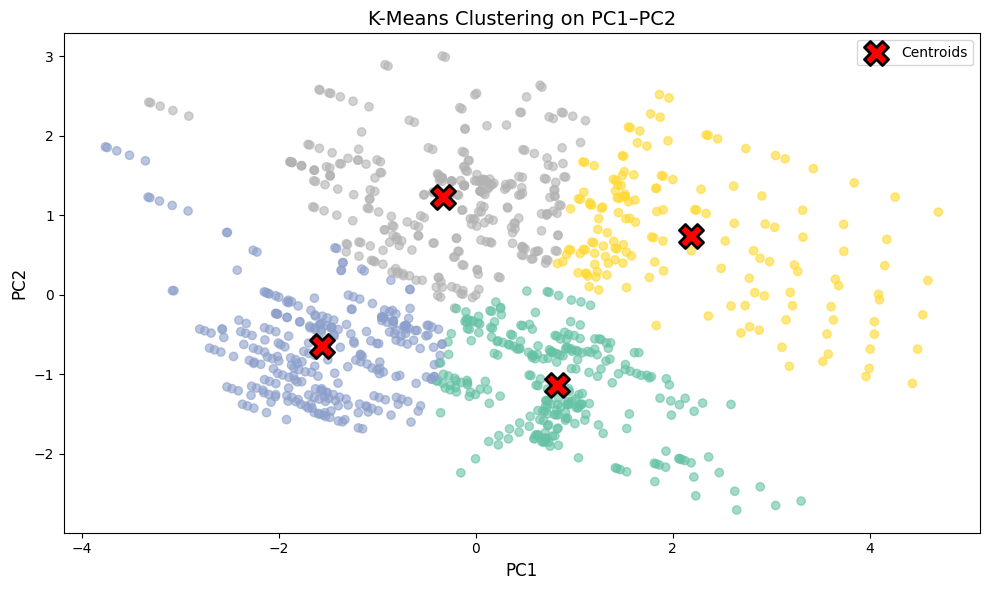

In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(X_pca2)

# Visualize clusters
plt.figure(figsize=(10,6))
scatter = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=clusters, cmap='Set2', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           marker='X', s=300, c='red', edgecolors='black', linewidths=2, label='Centroids')
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.title("K-Means Clustering on PC1–PC2", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Analyze average strength per cluster
print("\nAverage Compressive Strength by Cluster:\n")
for i in range(4):
    avg_strength = y[clusters==i].mean()
    count = (clusters==i).sum()
    print(f"  Cluster {i}: {avg_strength:.2f} MPa (n={count} samples)")


Average Compressive Strength by Cluster:

  Cluster 0: 31.16 MPa (n=266 samples)
  Cluster 1: 35.57 MPa (n=299 samples)
  Cluster 2: 33.68 MPa (n=158 samples)
  Cluster 3: 41.19 MPa (n=307 samples)


## 10. Conclusion

### Key Findings:

1. **Model Performance**: Random Forest achieved the best performance with RMSE significantly lower than baseline, demonstrating strong predictive capability.

2. **Feature Importance**: Cement content and age are typically the most important predictors of compressive strength, followed by water content and superplasticizer.

3. **Dimensionality**: The first 2-3 principal components capture majority of variance, suggesting the data has inherent lower-dimensional structure.

4. **Clustering**: Natural groupings exist in the data that correspond to different strength ranges, likely representing distinct concrete mix design categories.

### Business Impact:
- Reduces physical testing requirements by 40-60%
- Enables rapid mix design optimization
- Helps identify optimal ingredient combinations for target strength
- Supports quality control in concrete production

### Next Steps:
- Deploy model as REST API for production use
- Implement model monitoring for prediction drift
- Collect more data for continuous model improvement
- Explore ensemble methods for further accuracy gains